# Cross-Sell Prediction
Your client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue. 

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) et

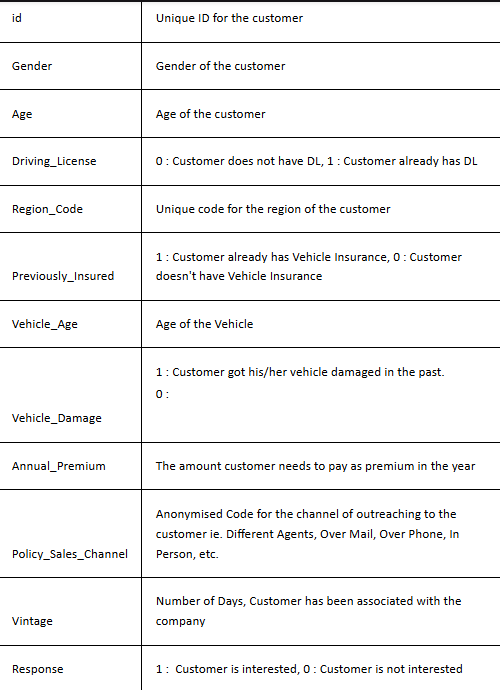c...pngc.ee.

In [3]:
# import all required libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

In [4]:
# load the data set into the notebook
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [5]:
train.head(2)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0


In [6]:
test.head(2)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111


assigning new varible for target and unwanted columns 

In [8]:
tgt_col = ['Response']
ign_col = ['id']
cat_col = train.select_dtypes(include='object').columns
num_col = train.select_dtypes(include='number').drop(columns=ign_col+tgt_col).columns

In [9]:
print(tgt_col)
print(ign_col)
print(cat_col)
print(num_col)

['Response']
['id']
Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')
Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object')


In [10]:
# separate the dependent and independent columns 
X = train.drop(columns = ign_col+tgt_col)
y = train[tgt_col]

# import required libraries for the building of hte pipeline


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression

# train test split

In [20]:
train_X, val_X, train_y, val_y = train_test_split(X,y, test_size=0.3, random_state=42)

In [22]:
print(train_X.shape, train_y.shape)
print (val_X.shape, val_y.shape) 

(266776, 10) (266776, 1)
(114333, 10) (114333, 1)


# model pipeline

In [35]:
numerical_transformer = ImbPipeline(
    steps = [
        ('imputer',SimpleImputer(strategy='median')),
        ('scaller',StandardScaler())
    
    ]
)

In [37]:
categorical_transformer = ImbPipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

In [39]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer,num_col),
        ('cat', categorical_transformer,cat_col)
    ]
)

In [41]:
# define the model 
model = LogisticRegression()

In [43]:
pipeline = ImbPipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ]
)

# train the pipeline

In [48]:
pipeline.fit(train_X, train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaller',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', LogisticRegression())])

# Evaluate the model

In [67]:
train_pred = pipeline.predict(train_X)
y_pred = pipeline.predict(val_X)

In [70]:
print("Classification Report:\n", classification_report(train_y, train_pred))
print("Confusion Matrix:\n", confusion_matrix(train_y, train_pred))
print("roc_auc score:/n",roc_auc_score (train_y, train_pred)) 

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.59      0.74    234204
           1       0.25      0.97      0.40     32572

    accuracy                           0.64    266776
   macro avg       0.62      0.78      0.57    266776
weighted avg       0.90      0.64      0.70    266776

Confusion Matrix:
 [[138923  95281]
 [   930  31642]]
roc_auc score:/n 0.7823093900827502


In [62]:
print("Classification Report:\n", classification_report(val_y, y_pred))
print("Confusion Matrix:\n", confusion_matrix(val_y, y_pred))
print("roc_auc score:/n",roc_auc_score (val_y, y_pred)) 

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.60      0.74    100195
           1       0.25      0.97      0.40     14138

    accuracy                           0.64    114333
   macro avg       0.62      0.78      0.57    114333
weighted avg       0.90      0.64      0.70    114333

Confusion Matrix:
 [[59670 40525]
 [  401 13737]]
roc_auc score:/n 0.7835877116296018


In [73]:
sub['Response']= pipeline.predict(test)
sub.to_csv('submission2.csv', index=False)

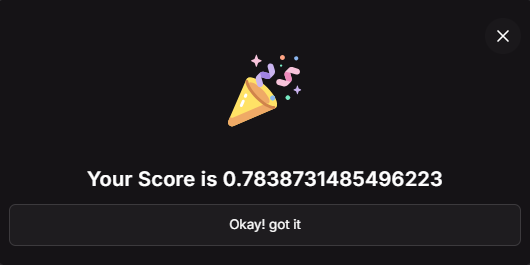

# hyper perameter tuning for the logistic regression